In [415]:
from pathlib import Path

req_path = Path("../../requirements.txt")
if req_path.exists():
    %pip install -qr {req_path}
else:
    %pip install -qU scikit-learn numpy pandas matplotlib seaborn phik jinja2 joblib category_encoders catboost xgboost

Note: you may need to restart the kernel to use updated packages.


In [416]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from phik import phik_matrix
from category_encoders import TargetEncoder

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor

from IPython.display import display

pd.set_option('display.max_columns', None)

In [417]:
RANDOM_STATE=42

In [418]:
train = pd.read_csv('dataset/train.csv', sep=',', decimal='.')
test = pd.read_csv('dataset/test.csv', sep=',', decimal='.')

In [419]:
display(train.head())
display(train.info())


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ MB


None

In [420]:
display(test.head())
display(test.info())


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy
2,630002,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,medium,moderate
3,630003,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,medium,moderate
4,630004,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,low,moderate


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                270000 non-null  int64  
 1   age               270000 non-null  int64  
 2   gender            270000 non-null  object 
 3   course            270000 non-null  object 
 4   study_hours       270000 non-null  float64
 5   class_attendance  270000 non-null  float64
 6   internet_access   270000 non-null  object 
 7   sleep_hours       270000 non-null  float64
 8   sleep_quality     270000 non-null  object 
 9   study_method      270000 non-null  object 
 10  facility_rating   270000 non-null  object 
 11  exam_difficulty   270000 non-null  object 
dtypes: float64(3), int64(2), object(7)
memory usage: 24.7+ MB


None

In [421]:
for column in [
    'study_hours',
    'class_attendance',
    'sleep_hours',
]:
    train[column] = pd.to_numeric(train[column], downcast='float')
    test[column] = pd.to_numeric(test[column], downcast='float')
 
train['exam_score'] = pd.to_numeric(train['exam_score'], downcast='float')
 
for column in [
    'id',
    'age',
]:
    train[column] = pd.to_numeric(train[column], downcast='integer')
    test[column] = pd.to_numeric(test[column], downcast='integer')

In [422]:
print("Число признаков:", train.shape[1])
print("Число объектов:", train.shape[0])

print("Число признаков:", test.shape[1])
print("Число объектов:", test.shape[0])

Число признаков: 13
Число объектов: 630000
Число признаков: 12
Число объектов: 270000


---

In [423]:
train.describe()

,id,age,study_hours,class_attendance,sleep_hours,exam_score
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,20.545821,4.002337,71.987267,7.072759,62.506672
std,181865.479132,2.260238,2.359880,17.430098,1.744811,18.916883
min,0.000000,17.000000,0.080000,40.599998,4.100000,19.599001
25%,157499.750000,19.000000,1.970000,57.000000,5.600000,48.799999
50%,314999.500000,21.000000,4.000000,72.599998,7.100000,62.599998
75%,472499.250000,23.000000,6.050000,87.199997,8.600000,76.300003
max,629999.000000,24.000000,7.910000,99.400002,9.900000,100.000000


In [424]:
useless_cols = ['id']

train = train.drop(columns=useless_cols)

In [425]:
print('Число явных дубликатов train:', train.duplicated().sum())
print('Число явных дубликатов test:', test.duplicated().sum())

train = train.drop_duplicates()
test = test.drop_duplicates()

Число явных дубликатов train: 0
Число явных дубликатов test: 0


In [426]:
cat_df = train.select_dtypes(include=['object'])

data = []
for col in cat_df.columns:
    data.append({
        'Признак': col,
        'Уникальные значения': train[col].unique(),
        'Кол-во': train[col].nunique(),
    })

pd.DataFrame(data)

,Признак,Уникальные значения,Кол-во
0,gender,"[female, other, male]",3
1,course,"[b.sc, diploma, bca, b.com, ba, bba, b.tech]",7
2,internet_access,"[no, yes]",2
3,sleep_quality,"[average, poor, good]",3
4,study_method,"[online videos, self-study, coaching, group study, mixed]",5
5,facility_rating,"[low, medium, high]",3
6,exam_difficulty,"[easy, moderate, hard]",3


In [427]:
discrete_cols = ['age']

def get_df_without_discrete(df, discrete_cols):
    for col in discrete_cols:
        if col in df.columns:
            df = df.drop(columns=col)

    return df

In [428]:
def create_boxplot(df, col, ax):
    sns.boxplot(
        data=df[col],
        ax=ax
    )
    
    ax.set_title(f'Размах значений признака: {col}')
    ax.set_ylabel('Значение признака')

    ax.grid(True)
    ax.tick_params(axis='x', rotation=30)
    
    return ax

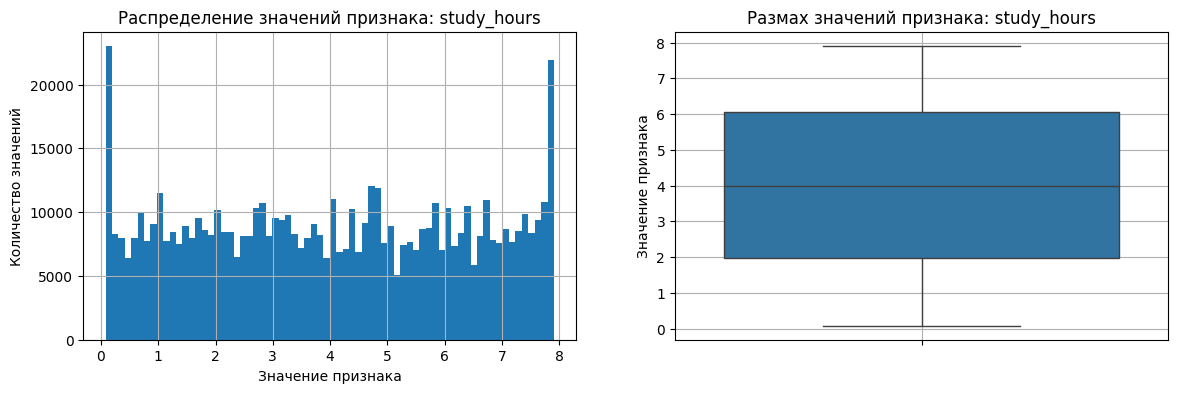

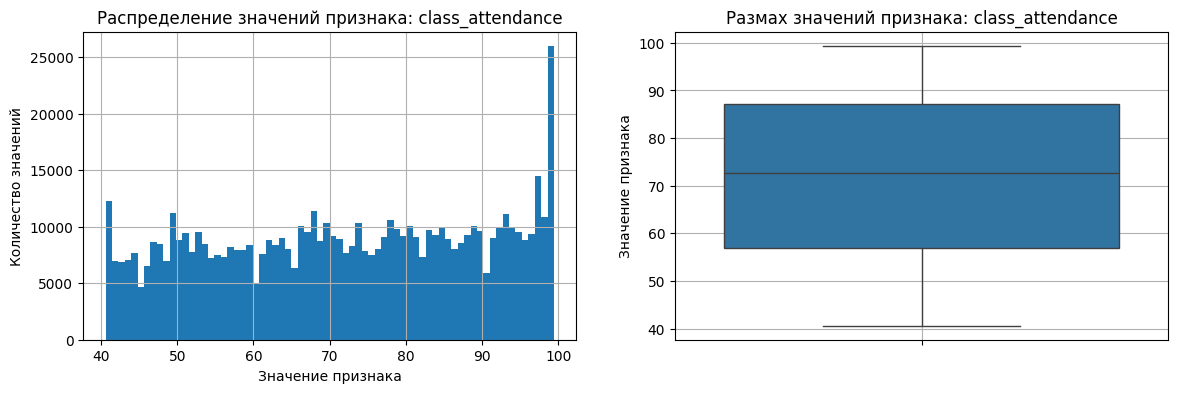

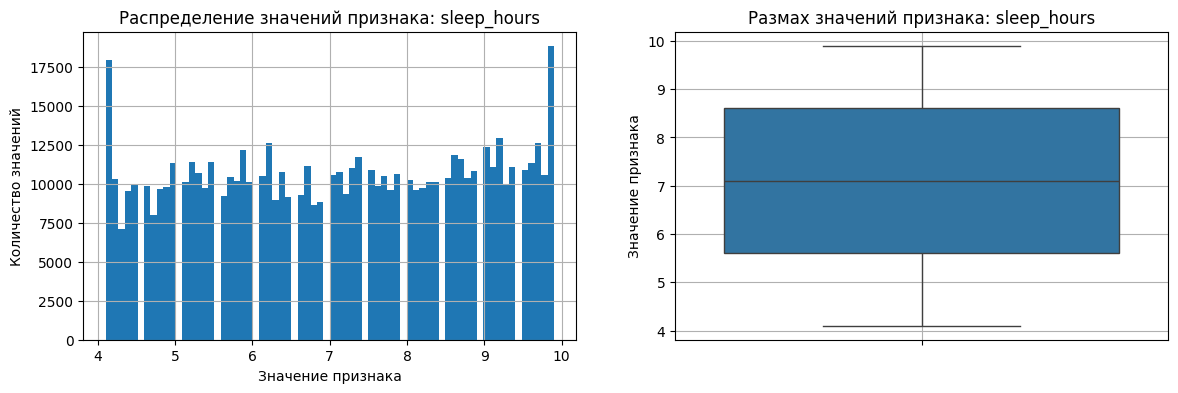

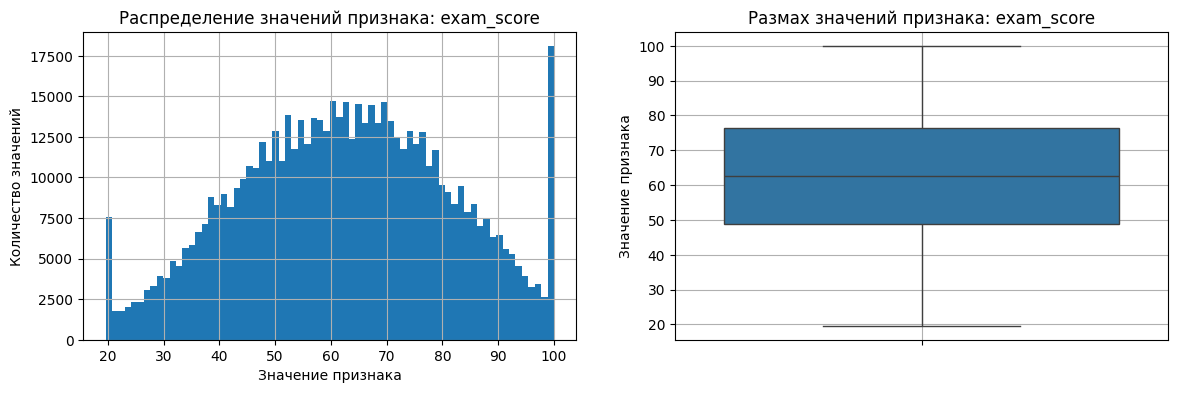

In [429]:
df_without_discrete = get_df_without_discrete(train, discrete_cols)
interval_df = df_without_discrete.select_dtypes(include=['number'])

for col in interval_df.columns:
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

    hist = axes[0]
    interval_df[col].plot(
        kind='hist',
        bins=70,
        grid=True,
        ax=hist,
    )
    
    hist.set_title(f'Распределение значений признака: {col}')
    hist.set_xlabel('Значение признака')
    hist.set_ylabel('Количество значений')
    
    create_boxplot(interval_df, col, axes[1])

    plt.show()
    
    plt.close()
    


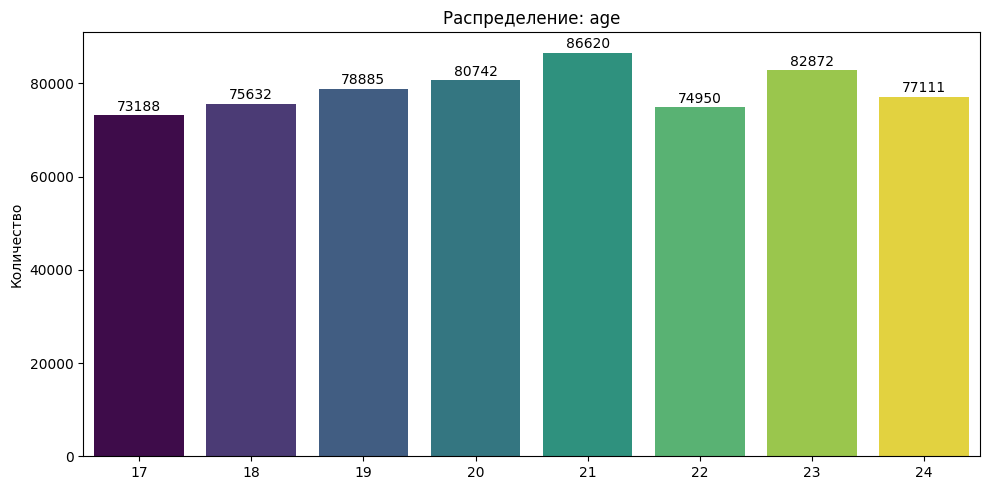

In [430]:
for col in discrete_cols:
    plt.figure(figsize=(10, 5)) 
    
    ax = sns.countplot(
        x=col,
        data=train,
        hue=col, 
        legend=False,
        palette='viridis'
    )
    
    plt.title(f'Распределение: {col}')
    plt.xlabel('')
    plt.ylabel('Количество')

    for container in ax.containers:
        ax.bar_label(container, label_type='edge', padding=1)

    plt.tight_layout()
    
    plt.show()
    plt.close()

In [431]:
def create_heatmap(corr, title):
    sns.heatmap(
        corr,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        linewidths=.5,
        cbar=False,
    )
    
    plt.title(title)

    plt.show()

/Users/katsay/develop/ml/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


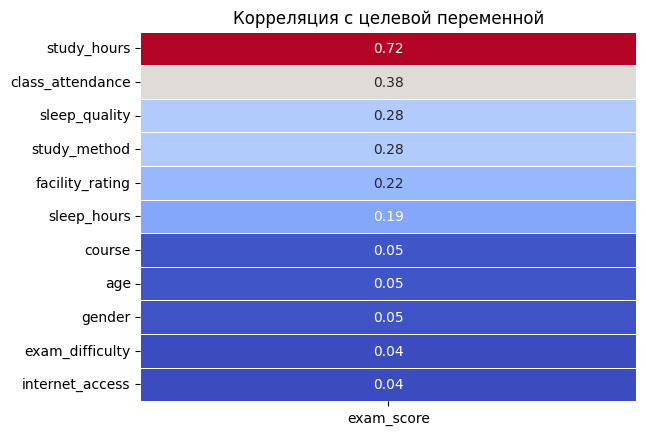

In [432]:
corr_matrix = train.phik_matrix(njobs=4, interval_cols=interval_df.columns)
target_correlation = corr_matrix[corr_matrix.index != 'exam_score'][['exam_score']].sort_values(by='exam_score', ascending=False)

create_heatmap(target_correlation, title='Корреляция с целевой переменной')

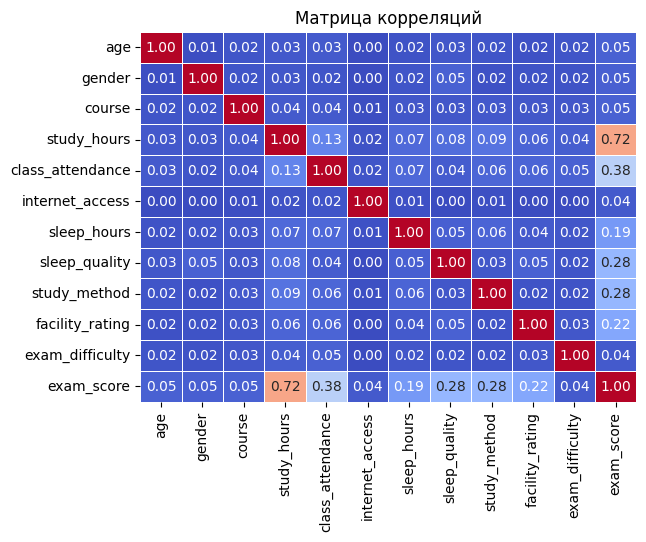

In [433]:
create_heatmap(corr_matrix, title='Матрица корреляций')

---

In [434]:
X = train.drop(columns=['exam_score'])
y = train['exam_score']

In [435]:
num_cols = X.select_dtypes(include=['number']).columns
cat_cols = X.select_dtypes(include=['object']).columns

In [436]:
for col in cat_cols:
    X[col] = X[col].astype("category")
    test[col] = test[col].astype("category")

In [437]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X[:200_000],
    y[:200_000],
    test_size=.2,
    shuffle=True,
    random_state=RANDOM_STATE
)

print(f"Размер обучающей выборки: {X_train_val.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Доля положительного класса в train: {y_train_val.mean():.3f}")
print(f"Доля положительного класса в test: {y_test.mean():.3f}")

Размер обучающей выборки: (160000, 11)
Размер тестовой выборки: (40000, 11)
Доля положительного класса в train: 62.519
Доля положительного класса в test: 62.520


In [438]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', TargetEncoder(smoothing=10), cat_cols)
])

In [439]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('var_thresh', VarianceThreshold(threshold=0.1)),
    ('correlation_filter', SelectKBest(score_func=f_regression, k='all')),
    ('model', LinearRegression())
])

In [440]:
cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

In [441]:
results = cross_validate(
    pipeline, 
    X_train_val,
    y_train_val, 
    cv=cv, 
    scoring=["neg_root_mean_squared_error"],
    return_estimator=True,
    n_jobs=4,
)
score = -results["test_neg_root_mean_squared_error"].mean()
print(f"[LinearRegression] RMSE: {score:.4f}")

[LinearRegression] RMSE: 8.9335


In [442]:
param_grid = [
    {
        'model': [Ridge(random_state=RANDOM_STATE)],
        'model__alpha': [1],
        'model__solver': ['saga'],
    },
    # {
    #     'model': [Lasso(random_state=RANDOM_STATE)],
    #     'model__alpha': [0.1],
    #     'model__selection': ['cyclic'],
    # },
    # {
    #     'model': [ElasticNet(random_state=RANDOM_STATE)],
    #     'model__alpha': [0.1],
    #     'model__l1_ratio': [0.9]
    # },
    # {
    #     'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
    #     'model__max_depth': [10],
    #     'model__min_samples_leaf': [20],
    #     'model__max_features': ['sqrt', 'log2', 0.5],
    # },
    # {
    #     'model': [ExtraTreeRegressor(random_state=RANDOM_STATE)],
    #     'model__min_samples_split': [10, 50, 100],
    #     'model__max_features': [0.5, 0.7, 'sqrt'],
    # },
    # {
    #     'model': [RandomForestRegressor(random_state=RANDOM_STATE)],
    #     'model__n_estimators': [100, 200],
    #     'model__max_samples': [0.5, 0.7],
    # },
]

In [443]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=4,
    verbose=1,
    return_train_score=False
)

print("Начинаем подбор гиперпараметров...")
grid_search.fit(X_train_val, y_train_val)

Начинаем подбор гиперпараметров...
Fitting 10 folds for each of 1 candidates, totalling 10 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...egression())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'model': [Ridge(random_state=42)], 'model__alpha': [1], 'model__solver': ['saga']}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",4
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fol

In [444]:
def show_results(grid_search, param_col, model=None):
    res_df = pd.DataFrame(grid_search.cv_results_)
    
    if model is None:
        res_df['model'] = res_df[param_col].apply(lambda x: x.__class__.__name__)
    else:
        res_df['model'] = model

    def format_params(params):
        return ", ".join(
            f"{key.replace('model__', '')}={val}"
            for key, val in params.items()
            if key != 'model'
        )
        
    res_df['params'] = res_df['params'].apply(format_params)
    res_df['mean_test_score'] = -res_df['mean_test_score']

    columns_to_show = [
        'model', 
        'params', 
        'mean_test_score', 
        'std_test_score',
        'rank_test_score'
    ]

    results_table = res_df[columns_to_show].sort_values(by='rank_test_score')
    results_table.columns = ['Model', 'Hyperparameters', 'RMSE', 'Std Dev', 'Rank']

    print("Топ-5 лучших моделей:")
    pd.set_option('display.max_colwidth', None)
    return results_table.head(5)
    
show_results(grid_search, 'param_model')

Топ-5 лучших моделей:


,Model,Hyperparameters,RMSE,Std Dev,Rank
0,Ridge,"alpha=1, solver=saga",8.933552,0.066127,1


In [445]:
param_grid = [
    {
        'n_estimators': [2000],
        'learning_rate': [0.01],
        'max_depth': [4],
        'min_child_weight': [3],
        'subsample': [0.7],
        'colsample_bytree': [0.7],
        'gamma': [0]
    }
]

In [446]:
xgb_grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=RANDOM_STATE, enable_categorical=True, n_estimators=1000),
    param_grid=param_grid,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=4,
    verbose=30,
    return_train_score=False
)

print("Начинаем подбор гиперпараметров...")
xgb_grid_search.fit(X_train_val, y_train_val)

Начинаем подбор гиперпараметров...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10; 1/1] START colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=2000, subsample=0.7
[CV 3/10; 1/1] START colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=2000, subsample=0.7
[CV 2/10; 1/1] START colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=2000, subsample=0.7
[CV 4/10; 1/1] START colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=2000, subsample=0.7
[CV 1/10; 1/1] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=2000, subsample=0.7;, score=-8.824 total time=   4.7s
[CV 5/10; 1/1] START colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=2000, subsample=0.7
[CV 4/10; 1/1] END colsample_bytree=0.7, gam

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBRegressor(...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'colsample_bytree': [0.7], 'gamma': [0], 'learning_rate': [0.01], 'max_depth': [4], ...}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",4
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for 

In [447]:
show_results(xgb_grid_search, 'params', 'XGBRegressor')

Топ-5 лучших моделей:


,Model,Hyperparameters,RMSE,Std Dev,Rank
0,XGBRegressor,"colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=2000, subsample=0.7",8.836561,0.060704,1


In [448]:
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший результат валидации (RMSE): {-grid_search.best_score_:.4f}")

print(f"Лучшие параметры: {xgb_grid_search.best_params_}")
print(f"Лучший результат валидации (RMSE): {-xgb_grid_search.best_score_:.4f}")

Лучшие параметры: {'model': Ridge(random_state=42), 'model__alpha': 1, 'model__solver': 'saga'}
Лучший результат валидации (RMSE): 8.9336
Лучшие параметры: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 2000, 'subsample': 0.7}
Лучший результат валидации (RMSE): 8.8366


In [449]:
X_train_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160000 entries, 153248 to 121958
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   age               160000 non-null  int8    
 1   gender            160000 non-null  category
 2   course            160000 non-null  category
 3   study_hours       160000 non-null  float32 
 4   class_attendance  160000 non-null  float32 
 5   internet_access   160000 non-null  category
 6   sleep_hours       160000 non-null  float32 
 7   sleep_quality     160000 non-null  category
 8   study_method      160000 non-null  category
 9   facility_rating   160000 non-null  category
 10  exam_difficulty   160000 non-null  category
dtypes: category(7), float32(3), int8(1)
memory usage: 4.3 MB


In [ ]:
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=1.0, solver='saga'))
])

knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(n_neighbors=50))
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

estimators = [
    ('ridge', ridge_pipeline),
    ('knn', knn_pipeline),
    ('rf', rf_pipeline),
    ('xgb', XGBRegressor(**xgb_grid_search.best_params_, enable_categorical=True)),
]

stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

results = cross_validate(
    stack_model, 
    X_train_val,
    y_train_val, 
    cv=cv, 
    scoring=["neg_root_mean_squared_error"],
    return_estimator=True,
    n_jobs=4,
    verbose=30,
)
score = -results["test_neg_root_mean_squared_error"].mean()
print(f"\n[StackingRegressor] RMSE: {score:.4f}")

In [470]:
stack_model.fit(X_train_val, y_train_val)

,"estimators estimators: list of (str, estimator)Base estimators which will be stacked together. Each element of thelist is defined as a tuple of string (i.e. name) and an estimatorinstance. An estimator can be set to 'drop' using `set_params`.","[('ridge', ...), ('knn', ...), ...]"
,"final_estimator final_estimator: estimator, default=NoneA regressor which will be used to combine the base estimators.The default regressor is a :class:`~sklearn.linear_model.RidgeCV`.",LinearRegression()
,"cv cv: int, cross-validation generator, iterable, or ""prefit"", default=NoneDetermines the cross-validation splitting strategy used in`cross_val_predict` to train `final_estimator`. Possible inputs forcv are:* None, to use the default 5-fold cross validation,* integer, to specify the number of folds in a (Stratified) KFold,* An object to be used as a cross-validation generator,* An iterable yielding train, test splits,* `""prefit""`, to assume the `estimators` are prefit. In this case, the estimators will not be refitted.For integer/None inputs, if the estimator is a classifier and y iseither binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used.In all other cases, :class:`~sklearn.model_selection.KFold` is used.These splitters are instantiated with `shuffle=False` so the splitswill be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.If ""prefit"" is passed, it is assumed that all `estimators` havebeen fitted already. The `final_estimator_` is trained on the `estimators`predictions on the full training set and are **not** cross validatedpredictions. Please note that if the models have been trained on the samedata to train the stacking model, there is a very high risk of overfitting... versionadded:: 1.1 The 'prefit' option was added in 1.1.. note:: A larger number of split will provide no benefits if the number of training samples is large enough. Indeed, the training time will increase. ``cv`` is not used for model evaluation but for prediction.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for `fit` of all `estimators`.`None` means 1 unless in a `joblib.parallel_backend` context. -1 meansusing all processors. See :term:`Glossary ` for more details.",None
,"passthrough passthrough: bool, default=FalseWhen False, only the predictions of estimators will be used astraining data for `final_estimator`. When True, the`final_estimator` is trained on the predictions as well as theoriginal training data.",False
,"verbose verbose: int, default=0Verbosity level.",0
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``

In [471]:
y_pred = stack_model.predict(X_test)
score = root_mean_squared_error(y_test, y_pred)

print(f"test RMSE: {score:.4f}")

test RMSE: 8.7637


In [472]:
stack_model.fit(X, y)

,"estimators estimators: list of (str, estimator)Base estimators which will be stacked together. Each element of thelist is defined as a tuple of string (i.e. name) and an estimatorinstance. An estimator can be set to 'drop' using `set_params`.","[('ridge', ...), ('knn', ...), ...]"
,"final_estimator final_estimator: estimator, default=NoneA regressor which will be used to combine the base estimators.The default regressor is a :class:`~sklearn.linear_model.RidgeCV`.",LinearRegression()
,"cv cv: int, cross-validation generator, iterable, or ""prefit"", default=NoneDetermines the cross-validation splitting strategy used in`cross_val_predict` to train `final_estimator`. Possible inputs forcv are:* None, to use the default 5-fold cross validation,* integer, to specify the number of folds in a (Stratified) KFold,* An object to be used as a cross-validation generator,* An iterable yielding train, test splits,* `""prefit""`, to assume the `estimators` are prefit. In this case, the estimators will not be refitted.For integer/None inputs, if the estimator is a classifier and y iseither binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used.In all other cases, :class:`~sklearn.model_selection.KFold` is used.These splitters are instantiated with `shuffle=False` so the splitswill be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.If ""prefit"" is passed, it is assumed that all `estimators` havebeen fitted already. The `final_estimator_` is trained on the `estimators`predictions on the full training set and are **not** cross validatedpredictions. Please note that if the models have been trained on the samedata to train the stacking model, there is a very high risk of overfitting... versionadded:: 1.1 The 'prefit' option was added in 1.1.. note:: A larger number of split will provide no benefits if the number of training samples is large enough. Indeed, the training time will increase. ``cv`` is not used for model evaluation but for prediction.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for `fit` of all `estimators`.`None` means 1 unless in a `joblib.parallel_backend` context. -1 meansusing all processors. See :term:`Glossary ` for more details.",None
,"passthrough passthrough: bool, default=FalseWhen False, only the predictions of estimators will be used astraining data for `final_estimator`. When True, the`final_estimator` is trained on the predictions as well as theoriginal training data.",False
,"verbose verbose: int, default=0Verbosity level.",0
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``

In [473]:
X_test = test.drop(columns=useless_cols)

y_pred = stack_model.predict(X_test)

submissions = pd.DataFrame({
    'id': test['id'],
    'exam_score': y_pred
})

submissions.to_csv('dataset/submissions.csv', index=False)